In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle

import requests, StringIO
from PIL import Image
import astroquery
from astroquery.sdss import SDSS

%matplotlib inline

def imtoasinh(im_data):
    asinh_percentile=[0.25,99.5]
    asinh_midpoint=-0.07

    im_gray=im_data.copy()
    im_gray = np.nan_to_num(im_gray)
    im_gray_percentile=np.percentile(im_gray,asinh_percentile)
    im_gray_min=im_gray_percentile[0]
    im_gray_max=im_gray_percentile[1]

    print "FITS image - min=%.2f  max=%.2f" % (im_gray_min, im_gray_max)

    im_gray=(im_gray-im_gray_min)/(im_gray_max-im_gray_min)
    im_gray=np.arcsinh(im_gray/asinh_midpoint)/np.arcsinh(1./asinh_midpoint)
    im_gray = np.nan_to_num(im_gray)
    im_gray = np.clip(im_gray, 0., 1.)
    
    return im_gray

def sdss_cutout(coo):
    
    try:
        n_coo=len(coo)
    except:
        n_coo=1
        coo=[coo]
        
    impix = 320
    imsize = 1*u.arcmin
    cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'

    fig, ax = plt.subplots(figsize=(30,30), sharex=True, sharey=True)
    for i in range(len(coo)):
        ax = plt.subplot(np.ceil(np.sqrt(n_coo)),np.floor(np.sqrt(n_coo)),i+1)
        print 'Processing galaxy '+str(i+1)
        query_string = urllib.urlencode(dict(ra=coo[i].ra.deg, 
                                         dec=coo[i].dec.deg, 
                                         width=impix, height=impix, 
                                         scale=imsize.to(u.arcsec).value/impix))
        url = cutoutbaseurl + '?' + query_string

        r = requests.get(url)
        im_data=Image.open(StringIO.StringIO(r.content))
        
        ax.imshow(im_data)
        ax.axis('off')
        ax.text(0.05,0.05, str(i+1), transform=ax.transAxes, color='white', fontsize=14)
        
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

### Primero analizamos las galaxias elipticas de GalaxyZOO

In [96]:
cat_url='https://raw.githubusercontent.com/rpmunoz/PentaUC/master/Astronomia%20era%20informacion/data/SDSS_galaxyzoo_elipticas.csv'
cat_galaxyzoo=pd.read_csv(cat_url,header=0,sep=',')
cat_galaxyzoo.head()

,ID,ra,dec,votos
0,587736584965390473,217.002375,37.400917,36
1,588015508213727352,41.307375,-0.746111,32
2,587734949668257807,158.403875,11.702222,30
3,587738948284514416,156.077625,37.087222,17
4,587729653425897913,254.959417,33.830361,24


In [100]:
coo=SkyCoord(cat_galaxyzoo['ra'], cat_galaxyzoo['dec'], unit=(u.deg,u.deg))
for i in range(len(coo)):
    print 'Processing galaxy ', i+1, ' - Coo: ', coo[i]
    result = SDSS.query_region(coo[i], spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], radius=2*u.arcsec)
    if i==0:
        sdss_data=result
    else:
        sdss_data.add_row(np.array(result)[0])

cat_sdss_elipticas=pd.DataFrame(np.array(sdss_data))
cat_sdss_elipticas

Processing galaxy  1  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (217.002375, 37.40091667)>
Processing galaxy  2  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (41.307375, -0.74611111)>
Processing galaxy  3  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (158.403875, 11.70222222)>
Processing galaxy  4  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (156.077625, 37.08722222)>
Processing galaxy  5  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (254.95941667, 33.83036111)>
Processing galaxy  6  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (168.35254167, 36.17266667)>
Processing galaxy  7  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (217.250625, 25.36588889)>
Processing galaxy  8  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (28.04566667, 13.71805556)>
Processing galaxy  9  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (189.603125, 1.27877778)>
Processing galaxy  10  - Coo:  <SkyCoord (ICRS): (ra, dec) in deg
    (41.36254167, -0.75075)>
Processing galaxy  11  - Coo:  <SkyCoo

,ra,dec,u,g,r,i,z
0,217.002390,37.400913,17.58736,15.60366,14.69556,14.28900,13.96379
1,41.307385,-0.746131,17.76154,15.75966,14.81796,14.40375,14.02473
2,158.403888,11.702202,18.09399,16.24945,15.43164,15.04739,14.78136
3,156.077625,37.087213,19.08807,17.07669,16.07527,15.64609,15.29820
4,254.959432,33.830356,20.29933,18.34799,17.17107,16.69359,16.35683
5,168.352530,36.172657,19.70474,17.82497,16.69294,16.24930,15.93570
6,217.250639,25.365865,18.97654,17.11012,16.11225,15.65098,15.27199
7,28.045629,13.718043,19.60862,17.64393,16.58624,16.13182,15.76712
8,189.603128,1.278774,19.68569,17.56323,16.37514,15.89880,15.57225
9,41.362548,-0.750787,20.60588,18.25218,16.99905,16.50179,16.09216


Processing galaxy 1
Processing galaxy 2
Processing galaxy 3
Processing galaxy 4
Processing galaxy 5
Processing galaxy 6
Processing galaxy 7
Processing galaxy 8
Processing galaxy 9
Processing galaxy 10


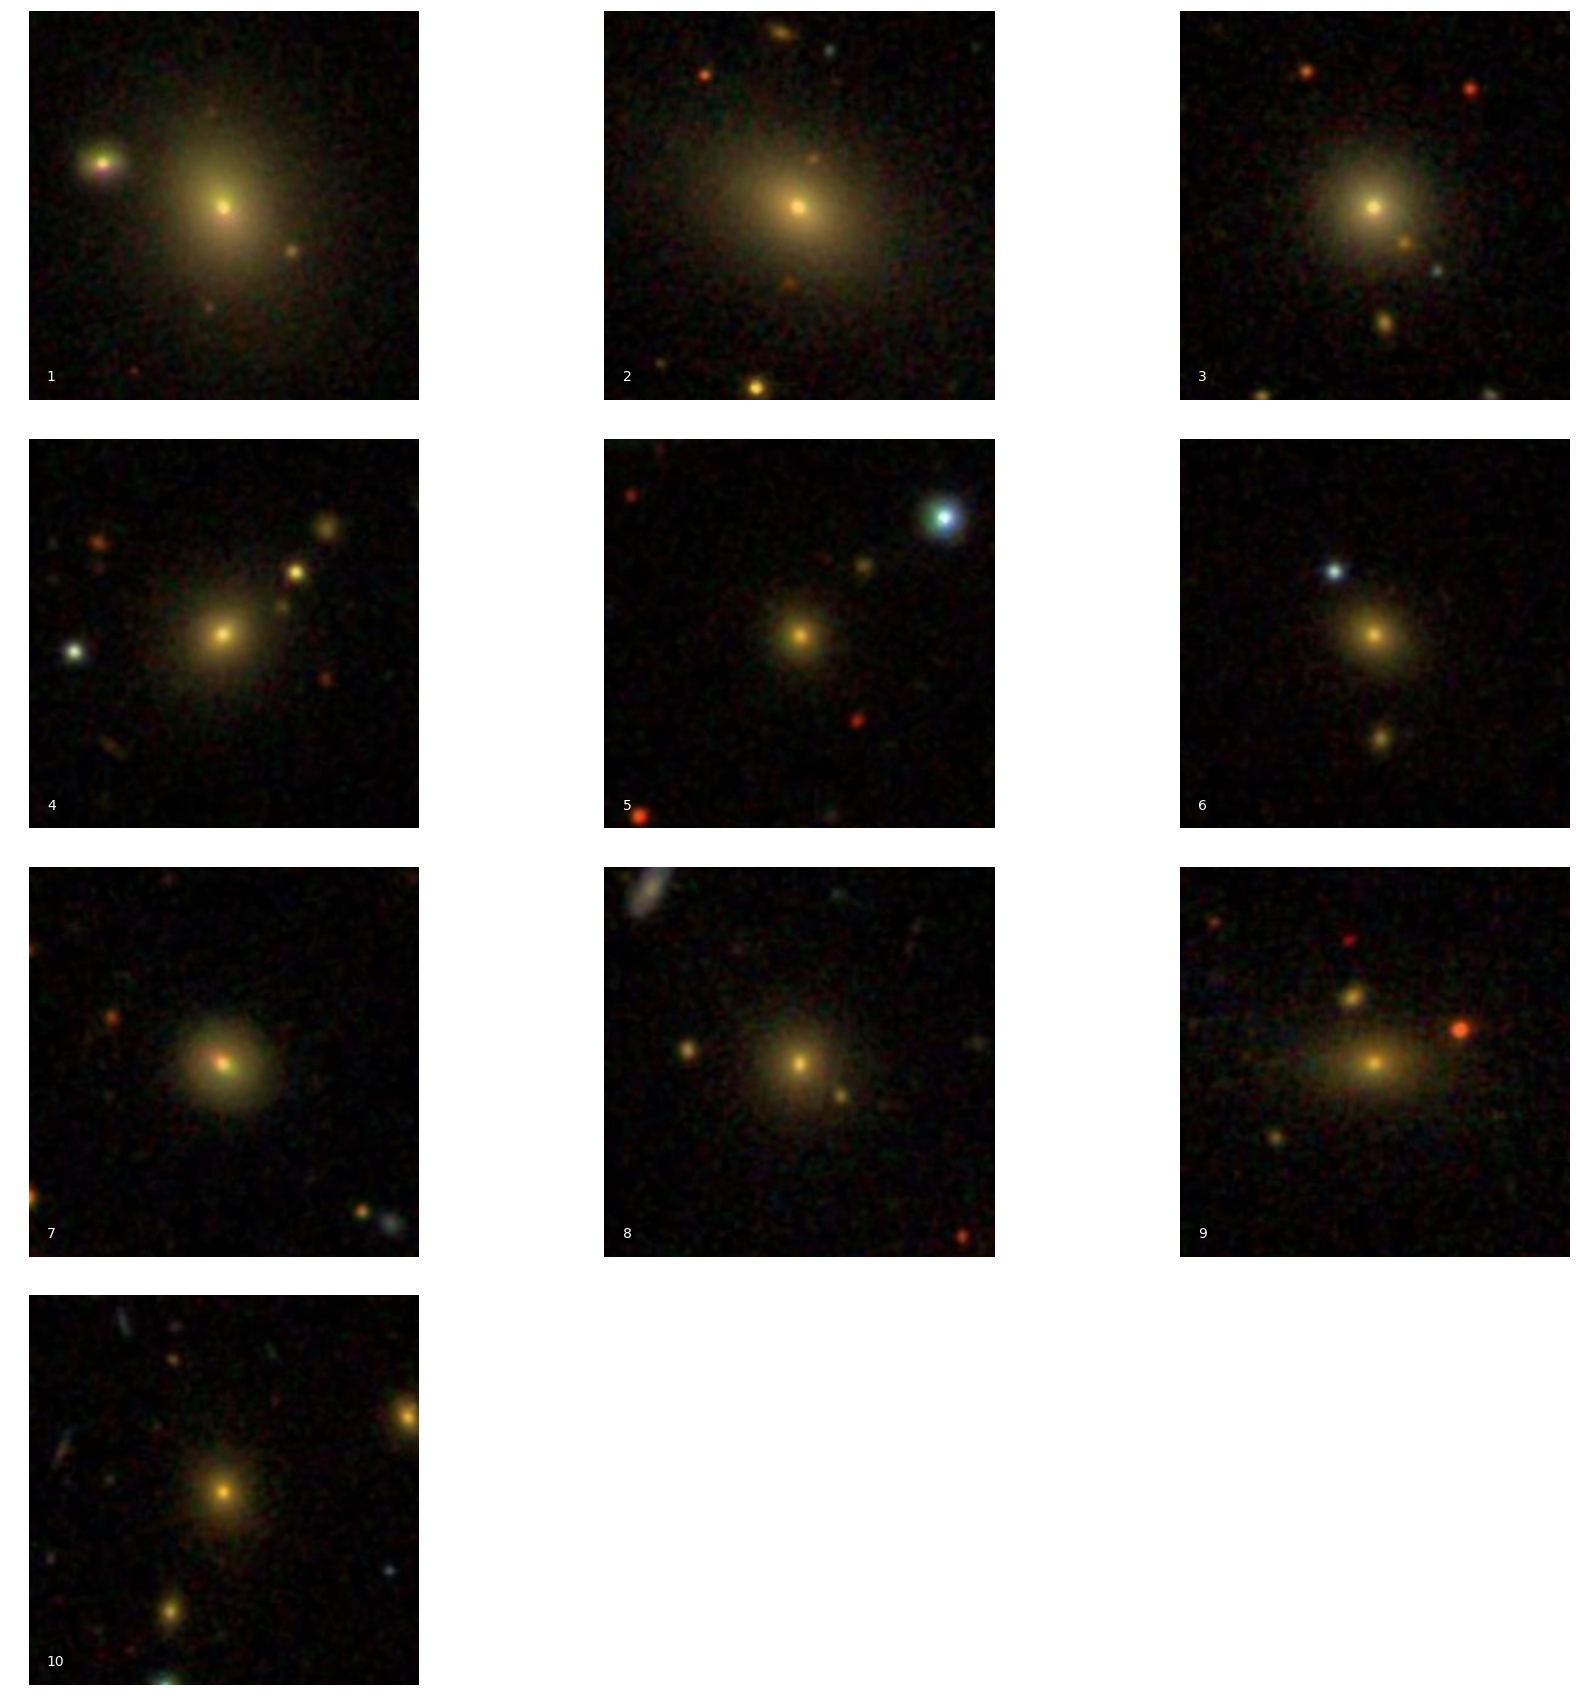

In [101]:
sdss_cutout(coo[0:10])

In [49]:
sdss_image=SDSS.get_images(coo[0], radius=15*u.arcsec, band='r')[0][0]

-0.123047
143.75
0.000200272


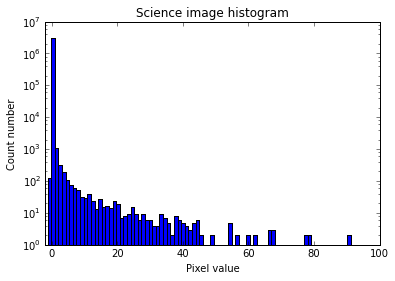

In [58]:
print np.min(sdss_image.data)
print np.max(sdss_image.data)
print np.median(sdss_image.data)
plt.hist(np.ndarray.flatten(sdss_image.data), bins=100, range=(-10.,100.))
plt.xlim(-2.,100.)
plt.ticklabel_format(useOffset=False)
plt.yscale('log')
plt.title('Science image histogram')
plt.xlabel('Pixel value')
plt.ylabel('Count number')

FITS image - min=-0.07  max=0.12


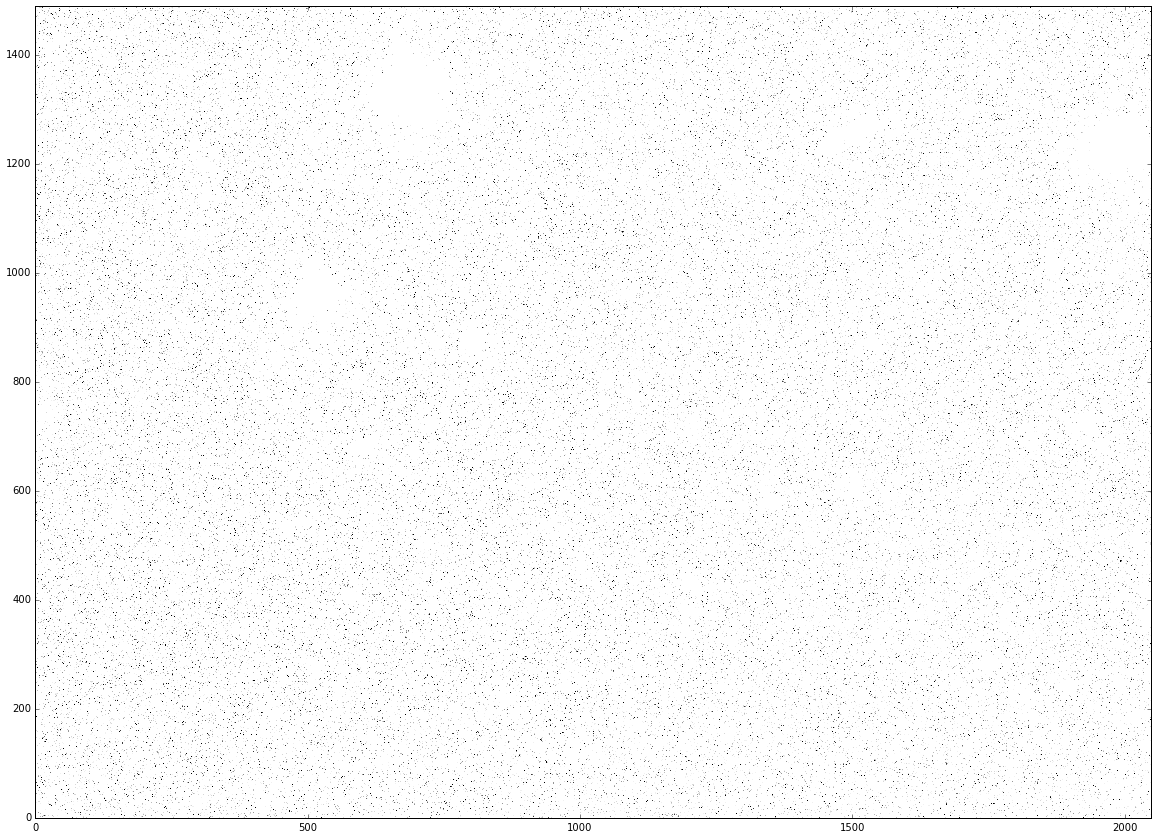

In [50]:
im_gray = imtoasinh(sdss_image.data)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(im_gray, plt.get_cmap('gray'), interpolation='nearest', origin='lower', vmin=0., vmax=0.5)
plt.show()

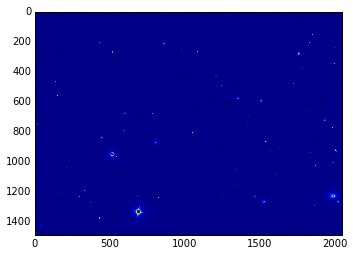

In [63]:
plt.imshow(sdss_image.data,vmin=-0.01, vmax=2)

### Luego analizamos las galaxias espirales de GalaxyZOO

In [ ]:
cat_url='https://raw.githubusercontent.com/rpmunoz/PentaUC/master/Astronomia%20era%20informacion/data/SDSS_galaxyzoo_espirales.csv'
cat_galaxyzoo=pd.read_csv(cat_url,header=0,sep=',')
cat_galaxyzoo.head()

In [ ]:
coo=SkyCoord(cat_galaxyzoo['ra'], cat_galaxyzoo['dec'], unit=(u.deg,u.deg))
for i in range(len(coo)):
    print 'Processing galaxy ', i, ' - Coo: ', coo[i]
    result = SDSS.query_region(coo[i], spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], radius=2*u.arcsec)
    if i==0:
        sdss_data=result
    else:
        sdss_data.add_row(np.array(result)[0])

cat_sdss_espirales=pd.DataFrame(np.array(sdss_data))
cat_sdss_espirales

## Apendices

Descargar el catalogo completo de Galaxy zoo

In [ ]:
import requests, zipfile, StringIO

In [ ]:
cat_url='http://galaxy-zoo-1.s3.amazonaws.com/GalaxyZoo1_DR_table2.csv.zip'

r = requests.get(cat_url)
z = zipfile.ZipFile(StringIO.StringIO(r.content))

cat_file='GalaxyZoo1_DR_table2.csv'
cat_data=pd.read_csv(z.open(cat_file))
cat_data.head()

In [ ]:
cat_data=cat_data.sort_values('P_EL_DEBIASED',ascending=0)
cat_elliptical=cat_data[cat_data['ELLIPTICAL']==1][0:100]
cat_elliptical['ra']=Angle(cat_elliptical['RA'], unit=u.hourangle).degree
cat_elliptical['dec']=Angle(cat_elliptical['DEC'], unit=u.degree).degree
cat_elliptical=cat_elliptical.rename(columns = {'OBJID':'ID','NVOTE':'votos'})
cat_elliptical=cat_elliptical[['ID','ra','dec','votos']].reset_index(drop=True)

cat_elliptical.to_csv('../data/SDSS_galaxyzoo_elipticas.csv',index=False)

In [ ]:
cat_data=cat_data.sort_values('P_CS_DEBIASED',ascending=0)
cat_spiral=cat_data[cat_data['SPIRAL']==1][0:100]
cat_spiral['ra']=Angle(cat_spiral['RA'], unit=u.hourangle).degree
cat_spiral['dec']=Angle(cat_spiral['DEC'], unit=u.degree).degree
cat_spiral=cat_spiral.rename(columns = {'OBJID':'ID','NVOTE':'votos'})
cat_spiral=cat_spiral[['ID','ra','dec','votos']].reset_index(drop=True)

cat_spiral.to_csv('../data/SDSS_galaxyzoo_espirales.csv',index=False)